### 1.

Define the following terms:

1. Gaussian Processes (GP) and, furthermore, general stochastic processes

- A stochastic process is basically a system that evolves randomly over time or space. For example, it would be like tracking the daily temperature, where each day's temperature is a random variable, and the entire sequence of daily temperatures over time is a stochastic process. A Gaussian process is a specific type of stochastic process where any collection of those random variables has a multivariate normal distribution. This means if we picked any set of points in time or space, the corresponding random variables will follow a joint Gaussian distribution. With a Gaussian process, we don't just estimate the curve itself, but also the uncertainties associated with each point on the curve, providing a probabilistic view of the data.

2. Variational Inference (VI) using Evidence Lower Bound (ELBO)

- Variational inference is a technique to approximate a probability distribution too complex for traditional calculations. Specifically in Bayesian framework, we use this by finding a more simpler distribution close to the true posterior, which is easier to work  with and derive. Evidence Lower Bound is, as the name suggest, a measure or bound of how well the simplified distribution approximates toward the true. It is a model selection algorithm akin to AIC or BIC, but unlike them, ELBO defines a better fit with higher scores.

### 2.

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import pymc as pm
import pytensor.tensor as pt

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "taimoor888/tesla-stock-price-data-2000-2025",
  "tesla_stock_data_2000_2025.csv"
)

df.head()

<ipython-input-219-571520c2216e>:13: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,Price,Close,High,Low,Open,Volume
0,Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-06-29,1.5926669836044312,1.6666669845581055,1.1693329811096191,1.2666670083999634,281494500
3,2010-06-30,1.5886670351028442,2.0280001163482666,1.553333044052124,1.7193330526351929,257806500
4,2010-07-01,1.4639999866485596,1.7280000448226929,1.3513330221176147,1.6666669845581055,123282000


Repurpose the PyMC documentation to demonstrate Gaussian Processes, but using a different dataset.

In [ ]:
df1 = df.iloc[2:].dropna()
df1 = df1.sample(25)
df1['Price'] = pd.to_datetime(df1['Price'])
df1 = df1.sort_values('Price')
df1['Days'] = (df1['Price'] - df1['Price'].min()).dt.days
df1 = df1[['Days', 'Close']]

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X = scaler_x.fit_transform(df1[['Days']].values).flatten()[:, None]
y = scaler_y.fit_transform(df1[['Close']].values).flatten().astype(float)

In [ ]:
with pm.Model() as TeslaGP:
    mean_func = pm.gp.mean.Zero()
    cov_func = pm.gp.cov.ExpQuad(input_dim=1, ls=1.0) + pm.gp.cov.WhiteNoise(1e-6)

    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    f = gp.prior("f", X=X)

    prior_samples = pm.sample_prior_predictive(50)

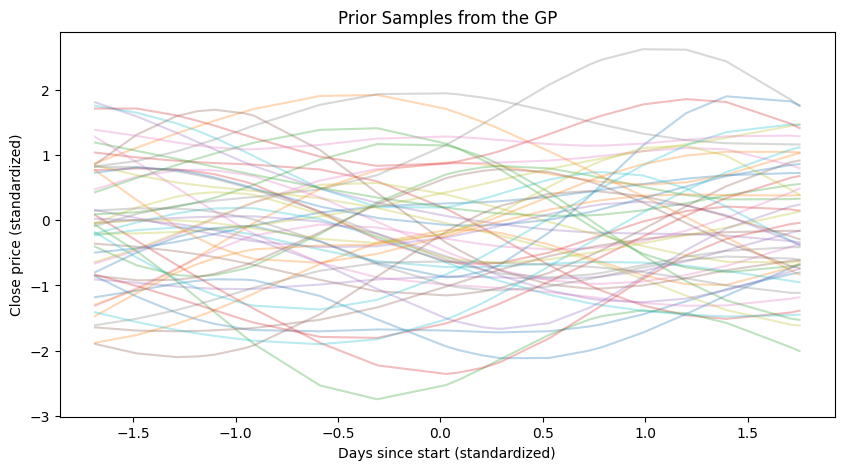

Output()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(X.flatten(), prior_samples.prior["f"].squeeze().T, alpha=0.3)
plt.title("Prior Samples from the GP")
plt.xlabel("Days since start (standardized)")
plt.ylabel("Close price (standardized)")
plt.show()

with TeslaGP:
    sigma = pm.HalfCauchy("sigma", beta=1)
    y_obs = pm.Normal("y_obs", mu=f, sigma=sigma, observed=y)
    idataGP = pm.sample()

Output()

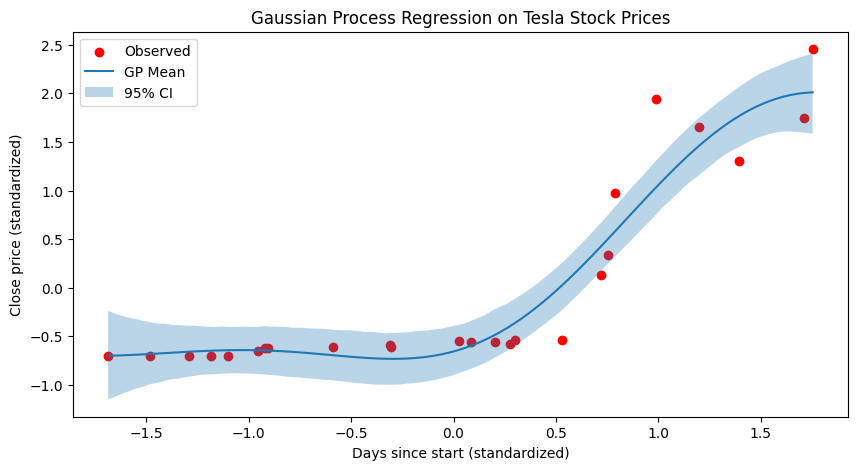

In [ ]:
X_new = np.linspace(X.min(), X.max(), 100)[:, None]
with TeslaGP:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(idataGP, var_names=["f_pred"])

f_pred_mean = pred_samples.posterior_predictive["f_pred"].mean(dim=["chain", "draw"]).to_numpy()
f_pred_lower = np.percentile(pred_samples.posterior_predictive["f_pred"].to_numpy(), 2.5, axis=(0, 1))
f_pred_upper = np.percentile(pred_samples.posterior_predictive["f_pred"].to_numpy(), 97.5, axis=(0, 1))

plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Observed", color="red")
plt.plot(X_new, f_pred_mean, label="GP Mean")
plt.fill_between(X_new.flatten(), f_pred_lower, f_pred_upper, alpha=0.3, label="95% CI")
plt.legend()
plt.xlabel("Days since start (standardized)")
plt.ylabel("Close price (standardized)")
plt.title("Gaussian Process Regression on Tesla Stock Prices")
plt.show()

### 3.

Repurpose the PyMC documentation to demonstrate a neural network fit with variational inference, but using a different dataset.

In [ ]:
df2 = df.iloc[2:].dropna()
df2 = df2.sample(100)
df2['Price'] = pd.to_datetime(df2['Price'])
df2 = df2.sort_values('Price')
df2['Days'] = (df2['Price'] - df2['Price'].min()).dt.days
df2['Close'] = df2['Close'].astype(float)
df2['High_Low'] = (df2['Close'] > df2['Close'].median())

X = scaler_x.fit_transform(df2[['Days']].values)
y = df2['High_Low'].values

In [ ]:
n_hidden = 10
with pm.Model() as VI_BNN:
    w_0 = pm.Normal("w_0", mu=0, sigma=1, shape=(1, n_hidden))
    b_0 = pm.Normal("b_0", mu=0, sigma=1, shape=(n_hidden,))
    w_1 = pm.Normal("w_1", mu=0, sigma=1, shape=(n_hidden, 1))
    b_1 = pm.Normal("b_1", mu=0, sigma=1, shape=(1,))

    act_1 = pm.math.tanh(pt.dot(X, w_0) + b_0)
    act_out = pm.math.sigmoid(pt.dot(act_1, w_1) + b_1)

    y_obs = pm.Bernoulli("y_obs", p=act_out.flatten(), observed=y)

    approx = pm.fit(n=10000, method='advi', obj_optimizer=pm.adam(learning_rate=0.01))
    idataBNN = approx.sample()

Output()

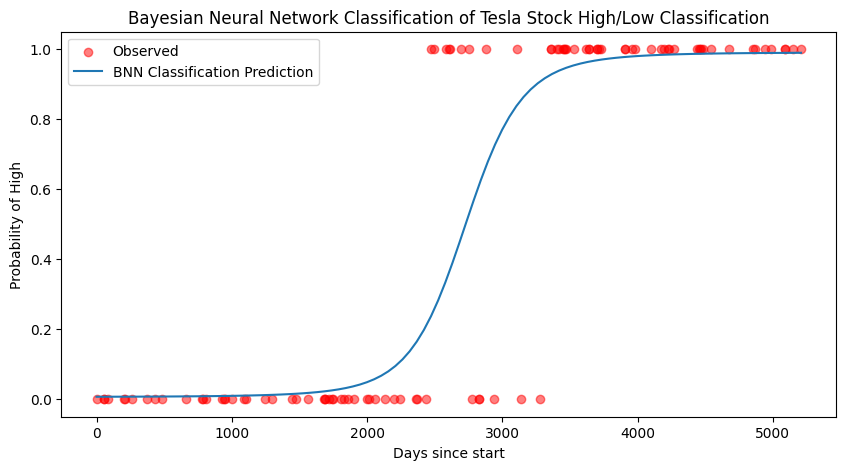

In [ ]:
X_new = np.linspace(X.min(), X.max(), 100)[:, None]
with VI_BNN:
    w_0_mean = idataBNN.posterior["w_0"].mean(dim=("chain", "draw")).values
    b_0_mean = idataBNN.posterior["b_0"].mean(dim=("chain", "draw")).values
    w_1_mean = idataBNN.posterior["w_1"].mean(dim=("chain", "draw")).values.squeeze()
    b_1_mean = idataBNN.posterior["b_1"].mean(dim=("chain", "draw")).values

    act_1_pred = np.tanh(np.dot(X_new, w_0_mean) + b_0_mean)

    f_pred = 1 / (1 + np.exp(-(np.dot(act_1_pred, w_1_mean) + b_1_mean)))

plt.figure(figsize=(10, 5))
plt.scatter(df2['Days'], df2['High_Low'], label="Observed", color="red", alpha=0.5)
plt.plot(scaler_x.inverse_transform(X_new), f_pred, label="BNN Classification Prediction")
plt.legend()
plt.xlabel("Days since start")
plt.ylabel("Probability of High")
plt.title("Bayesian Neural Network Classification of Tesla Stock High/Low Classification")
plt.show()